In [90]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.preprocessing import StandardScaler

In [6]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans


В данном задании вам предстоит дописать код класса MyKMeans. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [105]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию visualize_clusters, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [5]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

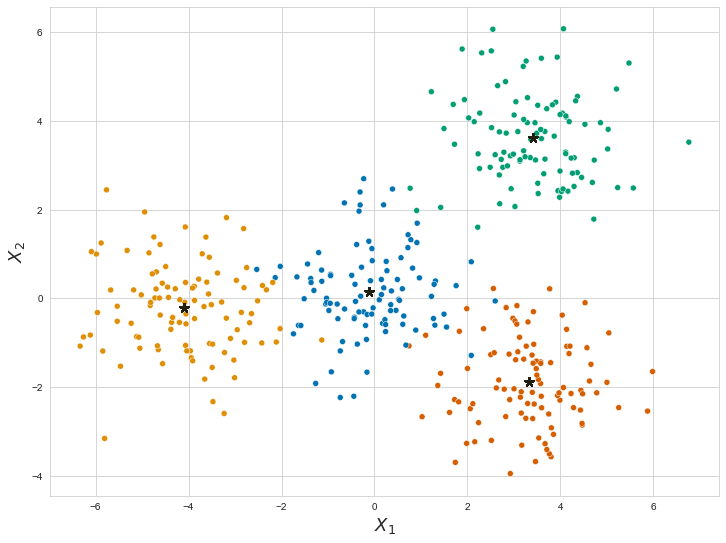

In [6]:
visualize_clusters(X, true_labels)

Напишем свой класс MyKMeans, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

Выбераем число кластеров (K)
Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
Этот "центр масс" становится новым центром кластера
Повторяем п.3, 4, 5 заданное число итераций или до сходимости
Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:

_calculate_distance(X, centroid) - вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
predict(X) - для каждого элемента из X возвращает номер кластера, к которому относится данный элемент

In [81]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=30, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        # Посчитаем расстояния для всех объектов до каждого центроида
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        # Для каждого объекта найдем, к какому центроиду он ближе
        cluster_labels = np.argmin(dists, axis=1)
        
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        

        dist = np.sum((X - centroid) ** 2, axis = 1) ** 0.5
        
        return dist.reshape(-1,1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите MyKMeans на наших игручешных данных, добейтесь сходимости. Не забудьте поставить visualize=True, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

In [95]:
kMeanModel_random= MyKMeans(4, visualize=True)

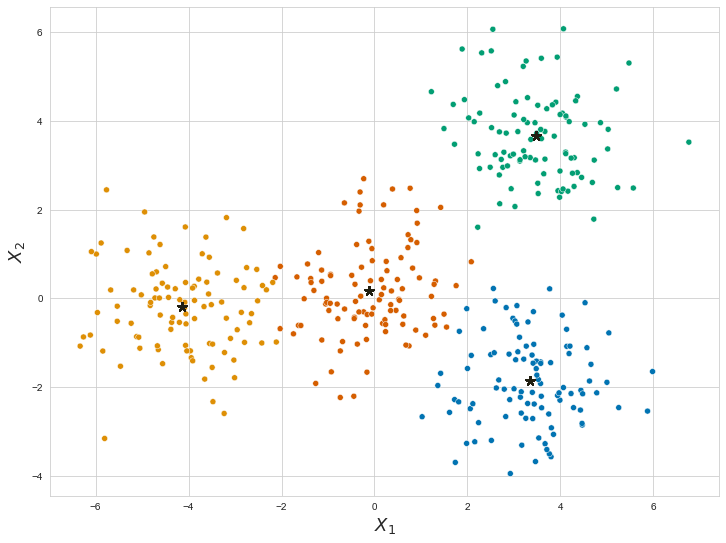

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [96]:
kMeanModel_random.fit(X)

In [100]:
clusters_pred = kMeanModel_random.predict(X)
for i in range (0, 4):
    print(i, np.sum(clusters_pred==i)) #выведем число точек в каждом кластере

0 100
1 99
2 97
3 104


In [98]:
kMeanModel_sample = MyKMeans(4, init = "sample", visualize=True) #пробуем другой способ инициализации центроидов

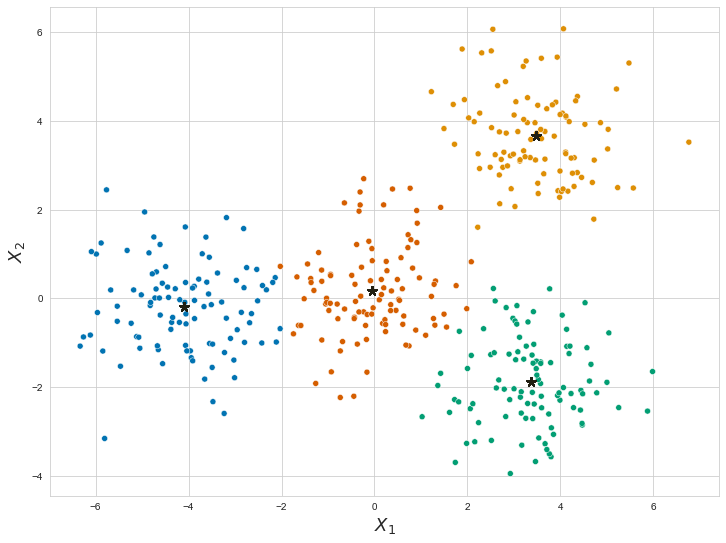

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [99]:
kMeanModel_sample.fit(X) #в целом, визуально тоже красиво отцентровал, но делал это как-то страшно

In [101]:
clusters_pred = kMeanModel.predict(X)
for i in range (0, 4):
    print(i, np.sum(clusters_pred==i)) #у нас немного поменялись местами метки и их цвета, но в целом важнее же, чтобы точки одного класса были отнесены к одному классу, вроде так и есть...

0 99
1 103
2 101
3 97


## Задание 2. Подбираем лучшую иерархическую кластеризацию
5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию algorithm_selection, которая будет на основании переданных ей:

метрик расстояния (можно брать все, что было на лекциях, минимум 4)
параметра linkage ('average', 'single', 'complete')
и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')
будет выводить итоговую таблицу, в которую войдут столбцы:

distance (метрика расстояния)
linkage (алгоритм иерархической кластеризации)
homogenity
completeness
v_measure
silhouette
В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [3]:
data = load_digits()
X, y = data.data, data.target

(-0.5, 7.5, 7.5, -0.5)

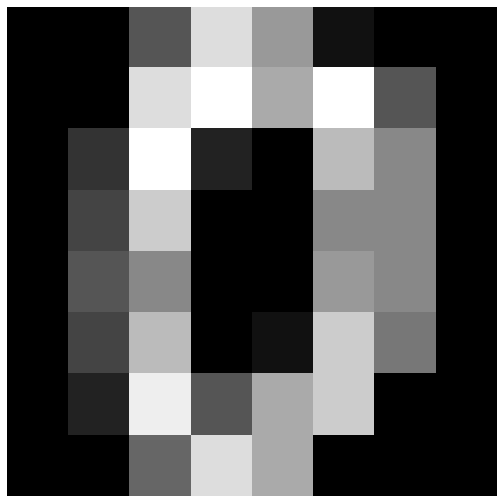

In [4]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off")

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать reshape в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции algorithm_selection, которую вы реализуете. Для некоторых метрик кластеризации требуются метки классов объектов (они хранятся в переменной y). Укажите для каждого алгоритма число кластеров равное количеству классов в y.

In [88]:
def algorithm_selection(X, distances, algorithms):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    scores_data = pd.DataFrame()
    for distance in distances:
        for linkage in algorithms:
            try:
                clustering = AgglomerativeClustering(n_clusters=10, affinity=str(distance), linkage=str(linkage))
                clustering.fit(X)
                labels_pred = clustering.labels_
                homogeneity = homogeneity_score(y, labels_pred)
                completeness = completeness_score(y, labels_pred)
                v = v_measure_score(y, labels_pred)
                silhouette = silhouette_score(X, labels_pred, metric=str(distance))
                temp_score_data = pd.DataFrame({'distance': [distance], 
                                                    'linkage': [linkage], 
                                                    'homogeneity': [homogeneity], 
                                                    'completeness':[completeness],
                                                    'v_measure':[v], 
                                                    'silhouette':[silhouette]})
                scores_data = scores_data.append(temp_score_data)
                
            except ValueError:
                continue
        

    compare_dataframe = scores_data
    
    return compare_dataframe

## Найдем лучшую комбинацию гиперпараметров для нашей классификации. Судя по всему, это euclidian-ward

In [80]:
distances = ['euclidean', 'l2', 'l1', 'manhattan', 'cosine']
algorithms = ['ward', 'complete', 'average', 'single']
algorithm_selection(X, distances, algorithms)

,distance,linkage,homogeneity,completeness,v_measure,silhouette
0,euclidean,ward,0.857513,0.879096,0.868170,0.178497
0,euclidean,complete,0.590549,0.637772,0.613253,0.119271
0,euclidean,average,0.655393,0.782342,0.713263,0.146625
0,euclidean,single,0.005056,0.273755,0.009929,-0.133621
0,l2,complete,0.590549,0.637772,0.613253,0.119271
0,l2,average,0.655393,0.782342,0.713263,0.146625
0,l2,single,0.005056,0.273755,0.009929,-0.133621
0,l1,complete,0.646372,0.686109,0.665648,0.140183
0,l1,average,0.566751,0.778942,0.656117,0.089217
0,l1,single,0.005102,0.276237,0.010019,-0.166627


# Задание 3. Аннотация клеточных типов
суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы FSC-A, SSC-A косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

## 3.1. EDA
1.5 балла

Проведите EDA:

Посмотрите на данные (можно попробовать метод describe)
Сколько у нас клеток / признаков
Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [102]:
fc_data1 = pd.read_csv('https://github.com/danon6868/BI-ml-course/raw/main/lesson_3_clustering/homework/data/flow_c_data.csv')

fc_data = fc_data1.drop(['Unnamed: 0'], axis =1)

Посмотрим на данные.

In [103]:
fc_data.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.962458,0.165415,1.791579,3.280391,5.169845,1.097182,0.412223,1.219683,0.569898
std,0.500012,0.190773,2.027281,2.112079,0.518247,1.375876,1.176967,2.285305,1.502445
min,0.144786,0.021657,-7.634172,-2.517639,-8.329666,-8.833883,-12.358701,-9.640775,-11.085437
25%,0.798804,0.105550,0.275056,1.401943,4.922227,0.389746,-0.195978,-0.146948,-0.498781
50%,0.908574,0.130543,1.194313,4.373660,5.234119,0.672853,0.053267,0.244121,0.272297
75%,1.052034,0.162536,3.696976,4.842212,5.481218,1.065076,0.378576,0.908374,1.220576
max,42.954485,15.460997,12.946668,13.844391,13.710922,6.294236,6.461899,7.208721,6.840864


всего 10к клеток
всего 10 колонок, но фичей 9, из них 2 - про размер, 7 про флуоресцентные метки
0 колонка - это номер, колонки FSC-A и SSC-A - о размерах клеток, у первого параметра разброс больше, остальные колонки - флуоресцентные метки с антигенам (HLA, CD3 и пр.), число говорит об интенсивности флуоресценции

посмотрим на распределение каждого признака

похоже, что FCA-A, SSC-a, CD45 распределены нормально, у остальных есть выраженные дополнительные пики (возможно, это способствует кластеризации?)


<AxesSubplot:xlabel='CD11c', ylabel='Density'>

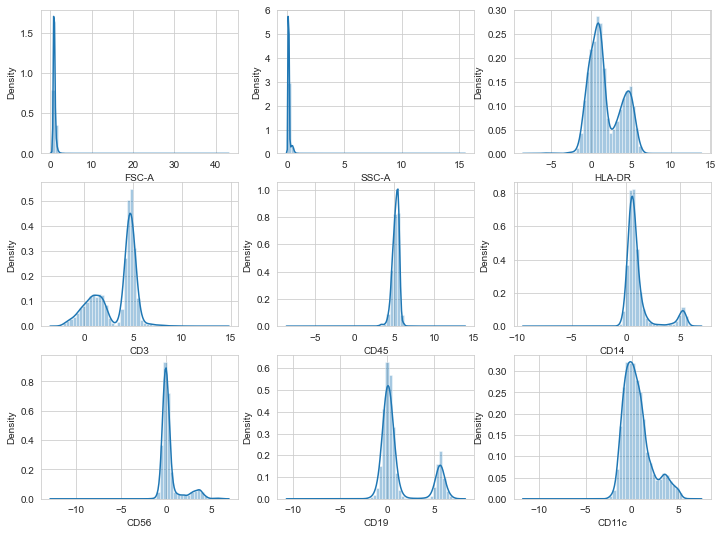

In [119]:
plt.subplot(3, 3, 1)
sns.distplot(fc_data['FSC-A'])

plt.subplot(3, 3, 2)
sns.distplot(fc_data['SSC-A'])


plt.subplot(3, 3, 3)
sns.distplot(fc_data['HLA-DR'])

plt.subplot(3, 3, 4)
sns.distplot(fc_data['CD3'])


plt.subplot(3, 3, 5)
sns.distplot(fc_data['CD45'])


plt.subplot(3, 3, 6)
sns.distplot(fc_data['CD14'])
 	

plt.subplot(3, 3, 7)
sns.distplot(fc_data['CD56'])
 

plt.subplot(3, 3, 8)
sns.distplot(fc_data['CD19'])


plt.subplot(3, 3, 9)
sns.distplot(fc_data['CD11c'])
	


## 3.2. Кластеризация
4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип
Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно тут.

In [26]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

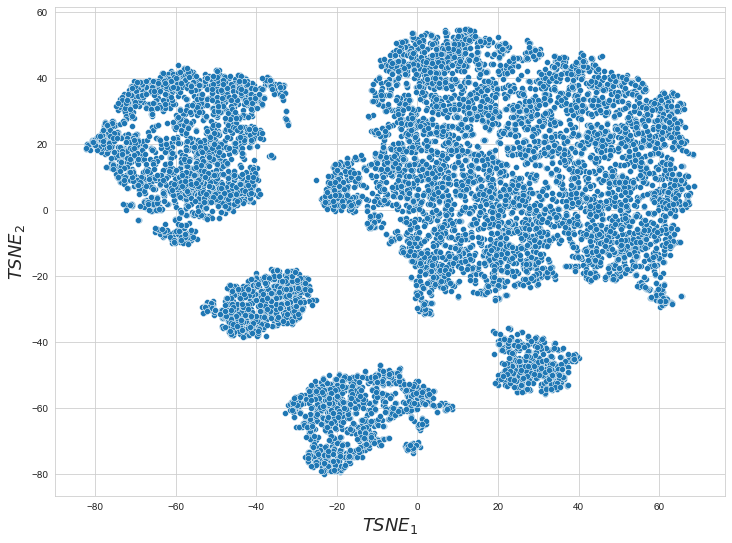

In [27]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

Попробуйте методы кластеризации из тех, что мы прошли
Выберите лучший на основании метрики silhouette_score (попробуйте также подобрать гиперпараметры)
Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

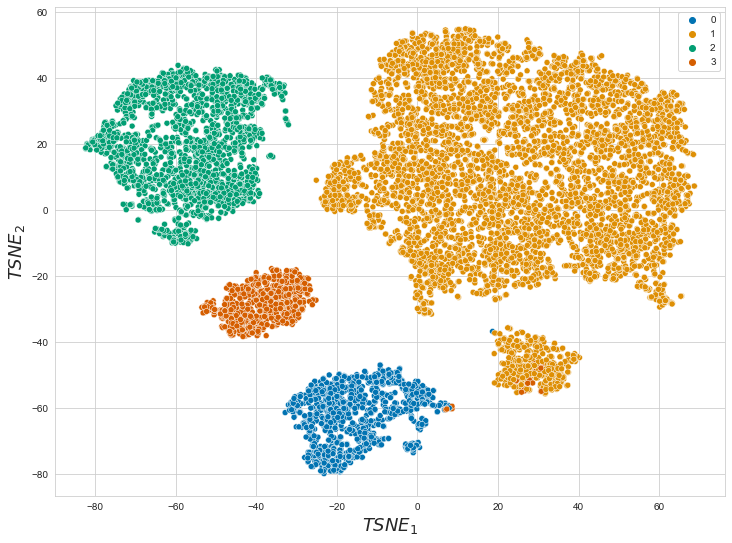

In [30]:
clf1 = KMeans(n_clusters=4, random_state=0).fit(fc_data) #ну, попробую обучить классификатор KMeans для начала с числом кластеров 4, 
labels_predicted = clf1.predict(fc_data) #предсказываю кластеры моим классификатором
tsne_res = plot_tsne(fc_data, color=labels_predicted) #отрисовываю картинку с раскрашенными кластерами

любопытно, что визуально на картинке как будто 5 групп, но оптимальная кластеризация - для 4 групп. Ну, это потому, что у нас на самом деле многомерное пространство, которое tSNE "вытягивает" в плоскость, и отдельная группа "вылезает", хотя в реальности в многомерном пространстве она, вероятно, пересекается с другим кластером

Ну и видно, что некоторые клетки явно отнесены к группе нелогично

### посчитаем метрику качества

In [32]:
silhouette_score(fc_data, labels_predicted) #получается, что кластеры довольно неплохо отделены

0.6103014000983125

попробуем оценить силуэт для разных вариантов числа кластеров при использовании KMeans

In [36]:
scores_data = pd.DataFrame()
for i in range(2, 10):
    clf1 = KMeans(n_clusters=i, random_state=0).fit(fc_data) 
    labels_predicted = clf1.predict(fc_data) 
    silhouette = silhouette_score(fc_data, labels_predicted)
    temp_score_data = pd.DataFrame({'n_clusters': [i], 'silhouette': [silhouette]})      
    scores_data = scores_data.append(temp_score_data)
scores_data

,n_clusters,silhouette
0,2,0.537198
0,3,0.608871
0,4,0.610301
0,5,0.350435
0,6,0.277807
0,7,0.283169
0,8,0.291599
0,9,0.271452


похоже, что число кластеров 4 дает самый нормальный результат метрики, но нас это все равно не устроит.
Попробуем другие варианты кластеризации. Для этого я сперва перепишу функцию algorithm_selection чтобы она брала 4 кластера и считала силуэт для всех вариантов сочетания гиперпараметров (придется убрать метрики гомогенности, v и полноты, потому что они просят вектор праивльных кластеров на вход, а у нас их теперь нет

In [84]:
def algorithm_selection(X, distances, algorithms):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    scores_data = pd.DataFrame()
    for distance in distances:
        for linkage in algorithms:
            try:
                clustering = AgglomerativeClustering(n_clusters=4, affinity=str(distance), linkage=str(linkage))
                clustering.fit(X)
                labels_pred = clustering.labels_

                silhouette = silhouette_score(X, labels_pred, metric=str(distance))
                temp_score_data = pd.DataFrame({'distance': [distance], 
                                                    'linkage': [linkage], 
                                                    'silhouette':[silhouette]})
                scores_data = scores_data.append(temp_score_data)
                
            except ValueError:
                continue
        

    compare_dataframe = scores_data
    
    return compare_dataframe

запускаю мою функцию, чтобы найти оптимальные параметры кластеризации путем агломеративной кластеризации

In [85]:
distances = ['euclidean', 'l2', 'l1', 'manhattan', 'cosine']
algorithms = ['ward', 'complete', 'average', 'single']
algorithm_selection(fc_data, distances, algorithms)

,distance,linkage,silhouette
0,euclidean,ward,0.611447
0,euclidean,complete,0.307133
0,euclidean,average,0.654419
0,euclidean,single,0.654419
0,l2,complete,0.307133
0,l2,average,0.654419
0,l2,single,0.654419
0,l1,complete,0.608927
0,l1,average,0.608927
0,l1,single,0.684616


Ну, получилось, что силуэт наивысший (и лучше, чем для KMeans), когда мы берем,  cosine расстоение и complete algorithm. Отрисую картинку tSNE для найденного лучшего варианта


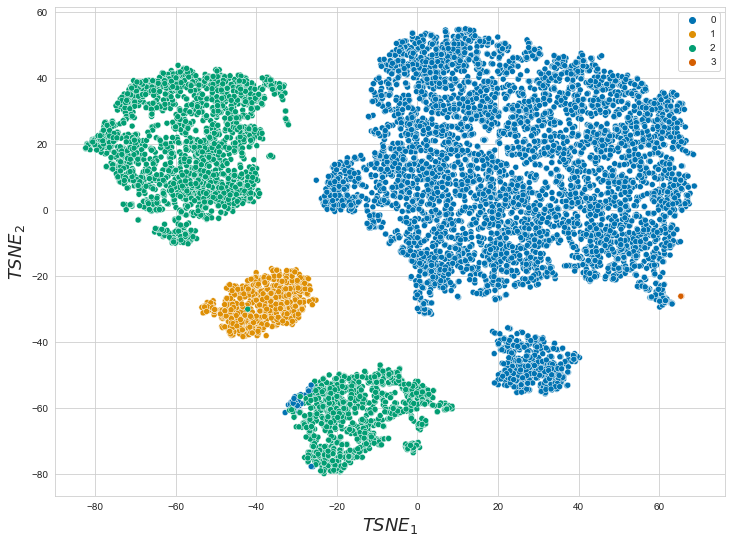

In [87]:
clf_best = AgglomerativeClustering(n_clusters=4, affinity = 'cosine', linkage='complete') 
clf_best.fit(fc_data)
labels_predicted = clf_best.labels_ #предсказываю кластеры моим классификатором
tsne_res = plot_tsne(fc_data, color=labels_predicted) #отрисовываю картинку с раскрашенными кластерами

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

А на картинке опять явно видно, что часть клеток, которые хотелось бы отнести к отдельному кластеру - покрашены в один цвет (зеленый)
Попробую алгоритм single и расстояние l1:

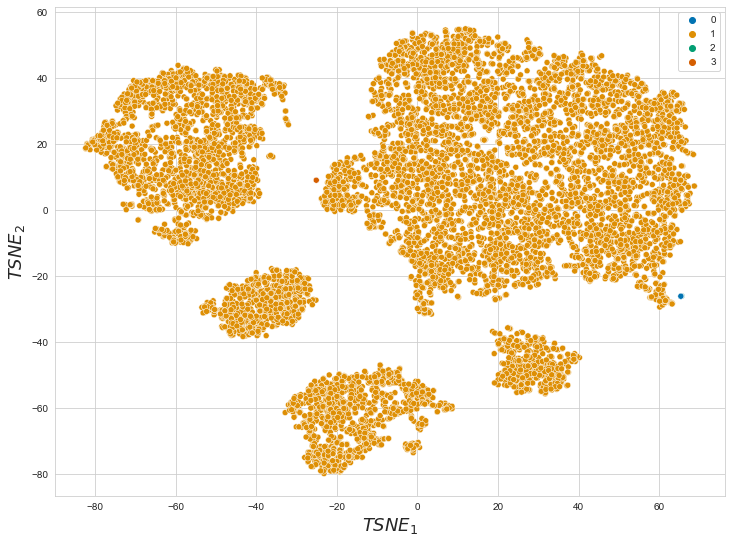

In [95]:
clf_best = AgglomerativeClustering(n_clusters=4, affinity = 'l1', linkage='single') 
clf_best.fit(fc_data)
labels_predicted = clf_best.labels_ #предсказываю кластеры моим классификатором
tsne_res = plot_tsne(fc_data, color=labels_predicted) #отрисовываю картинку с раскрашенными кластерами

ерунда тоже получилась. Пробую euclidean-ward

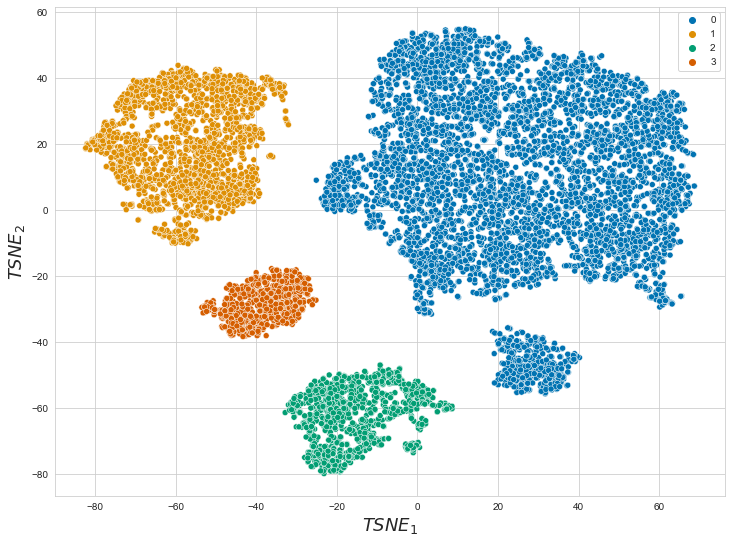

In [62]:
clf_best = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage='ward') 
clf_best.fit(fc_data)
labels_predicted = clf_best.labels_ #предсказываю кластеры моим классификатором
tsne_res = plot_tsne(fc_data, color=labels_predicted) #отрисовываю картинку с раскрашенными кластерами

он хотя бы классифицирует кластеры адекватно нашим ожиданиям и силуэт получается повыше, чем для Kmeans (0.611447)

# 3.3. Аннотация клеточных типов
4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

B_cells
T_cells
Monocytes
Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

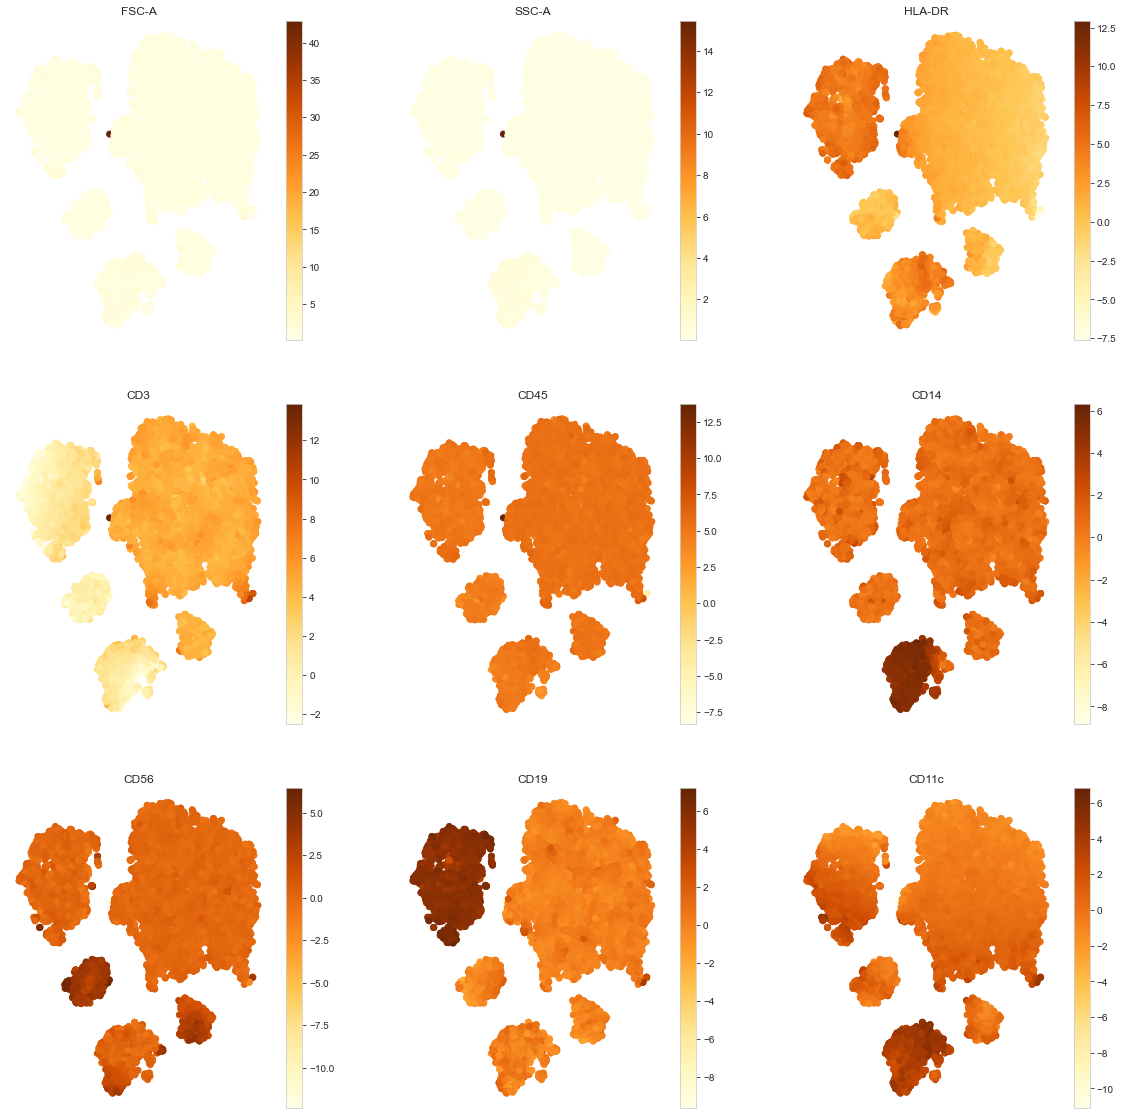

In [64]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре

Cd3 - маркер Tлимфоцитов
cd19 - маркер ранней клеточной дифференциации B клеток
CD11c и CD14 маркеры моноцитов и их потомков макрофагов

In [65]:
cell_type_cluster_map = {0: "T_cells", 
                         1: "B_cells", 
                         2: "Monocytes", 
                         3: "Other"}

In [68]:
labeled_fc_data = fc_data.assign(Population=labels_predicted) #добавим в табличку колонку с предсказанием типа клетки
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map) #вносим в колонку названия типов в соответствии с принятыми решениями относительно маркеров
labeled_fc_data

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c,Population
0,0.722199,0.154232,0.494449,0.512853,4.057328,1.019255,4.007273,-1.406912,0.384406,Other
1,0.751073,0.114618,4.671924,0.822042,4.933149,0.159388,-0.216407,6.034845,0.577039,B_cells
2,1.108188,0.150011,-0.422857,4.006353,5.616384,0.519223,0.783077,-0.318668,-0.493832,T_cells
3,0.553310,0.119929,0.345968,3.332310,5.260935,1.481229,0.264846,0.694883,3.416960,T_cells
4,0.774884,0.076984,4.984963,0.885501,4.562367,0.217117,0.086279,5.563345,0.471591,B_cells
...,...,...,...,...,...,...,...,...,...,...
9995,1.180762,0.441445,2.437344,1.526085,4.455114,4.880495,0.347480,-0.591343,2.857737,Monocytes
9996,0.768279,0.111863,0.812236,4.254496,5.008437,1.303261,-0.130244,0.344169,-0.626795,T_cells
9997,1.314964,0.233584,4.144130,1.311947,5.340263,1.598675,-0.287353,-0.887078,4.369294,Monocytes
9998,0.894135,0.137300,-0.226186,0.246804,4.430212,0.457881,2.404284,-0.112999,0.069239,Other


Посчитайте, как распределены типы клеток:

<AxesSubplot:>

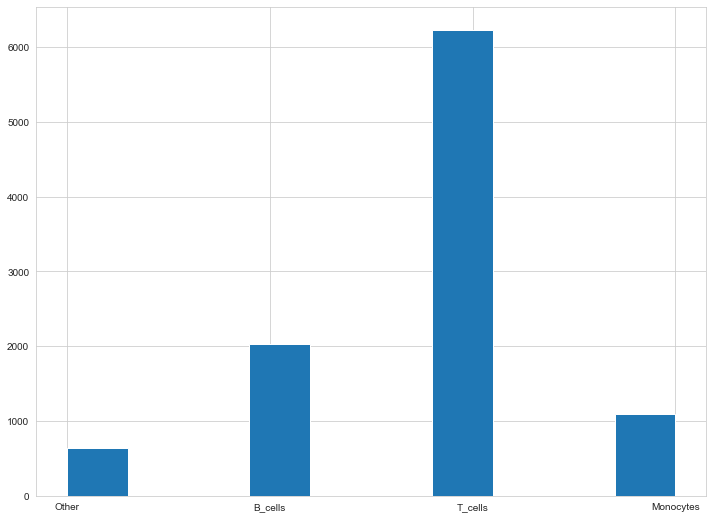

In [71]:
labeled_fc_data["Population"].hist()

In [72]:
labeled_fc_data["Population"].value_counts()

T_cells      6231
B_cells      2035
Monocytes    1099
Other         635
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике f1_score(average="macro"), которая хорошо подходит, даже если классы не сбалансированы.

In [73]:
labeled_fc_data.to_csv('labeled_fc_livanova.csv')

# Задание 4. Любимое место
дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)



В прошлом году была на Камчатке, хорошо бы было летом снова
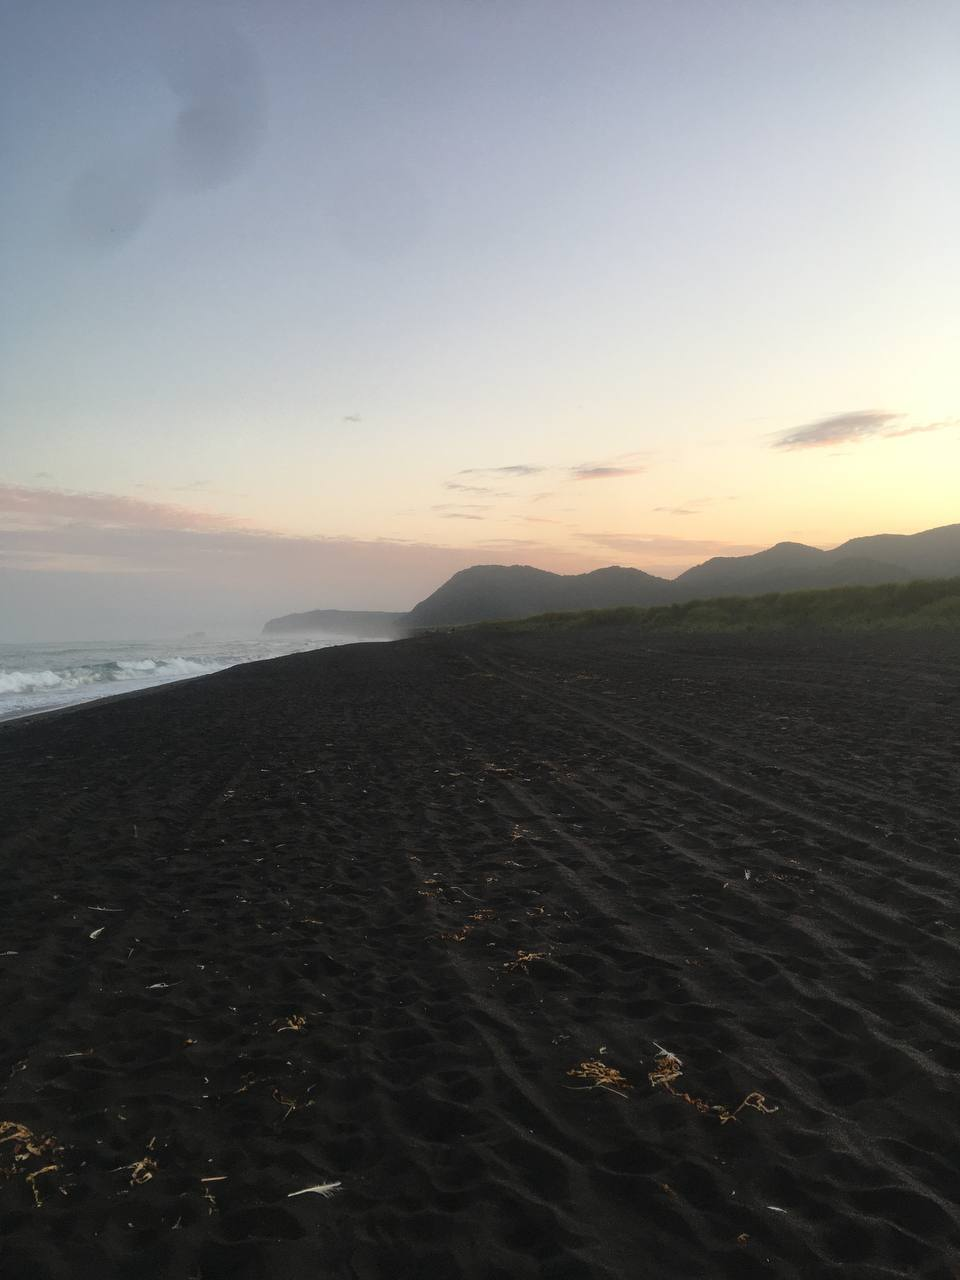